In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


import numpy as np
import matplotlib.pyplot as plt

In [2]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [3]:
train_x = train_images/255.0
test_x = test_images/255.0

train_y = tf.keras.utils.to_categorical(train_labels)
test_y = tf.keras.utils.to_categorical(test_labels)

In [4]:
def valid_callback(name):
    return [tf.keras.callbacks.EarlyStopping(monitor='val_ce', patience=20),
           tfdocs.modeling.EpochDots()]

In [5]:
def compile_and_fit(model, name, max_epochs=1000):
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.losses.CategoricalCrossentropy(from_logits=True, name='ce'),'accuracy'])
    
    history = model.fit(train_x, train_y, 
                        epochs=max_epochs, 
                        batch_size = 64,
                        callbacks=valid_callback(name), 
                        validation_data=(test_x, test_y))
    
    return history

histories={}

In [6]:
small = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(10)
])

histories['small'] = compile_and_fit(small, 'small')

Epoch 1/1000
782/782 [==============================] - 3s 3ms/step - loss: 1.9032 - ce: 1.9032 - accuracy: 0.3090 - val_loss: 1.7865 - val_ce: 1.7857 - val_accuracy: 0.3525

Epoch: 0, accuracy:0.3090,  ce:1.9032,  loss:1.9032,  val_accuracy:0.3525,  val_ce:1.7857,  val_loss:1.7865,  
.Epoch 2/1000
782/782 [==============================] - 3s 4ms/step - loss: 1.7607 - ce: 1.7608 - accuracy: 0.3643 - val_loss: 1.7231 - val_ce: 1.7227 - val_accuracy: 0.3765
.Epoch 3/1000
782/782 [==============================] - 2s 3ms/step - loss: 1.7133 - ce: 1.7132 - accuracy: 0.3864 - val_loss: 1.6936 - val_ce: 1.6928 - val_accuracy: 0.3942
.Epoch 4/1000
782/782 [==============================] - 2s 3ms/step - loss: 1.6800 - ce: 1.6799 - accuracy: 0.3980 - val_loss: 1.6680 - val_ce: 1.6677 - val_accuracy: 0.3969
.Epoch 5/1000
782/782 [==============================] - 3s 3ms/step - loss: 1.6536 - ce: 1.6535 - accuracy: 0.4073 - val_loss: 1.6621 - val_ce: 1.6626 - val_accuracy: 0.4044
.Epoch 6/1000


.Epoch 47/1000
782/782 [==============================] - 3s 3ms/step - loss: 1.4620 - ce: 1.4620 - accuracy: 0.4721 - val_loss: 1.5501 - val_ce: 1.5500 - val_accuracy: 0.4481
.Epoch 48/1000
782/782 [==============================] - 3s 4ms/step - loss: 1.4610 - ce: 1.4613 - accuracy: 0.4737 - val_loss: 1.5552 - val_ce: 1.5550 - val_accuracy: 0.4482
.Epoch 49/1000
782/782 [==============================] - 3s 3ms/step - loss: 1.4551 - ce: 1.4547 - accuracy: 0.4746 - val_loss: 1.5422 - val_ce: 1.5419 - val_accuracy: 0.4506
.Epoch 50/1000
782/782 [==============================] - 3s 3ms/step - loss: 1.4561 - ce: 1.4567 - accuracy: 0.4747 - val_loss: 1.5803 - val_ce: 1.5801 - val_accuracy: 0.4360
.Epoch 51/1000
782/782 [==============================] - 3s 4ms/step - loss: 1.4559 - ce: 1.4560 - accuracy: 0.4744 - val_loss: 1.5628 - val_ce: 1.5624 - val_accuracy: 0.4389
.Epoch 52/1000
782/782 [==============================] - 3s 4ms/step - loss: 1.4510 - ce: 1.4506 - accuracy: 0.4759 - v

In [7]:
medium = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(10)
])

histories['medium'] = compile_and_fit(medium, 'medium')

Epoch 1/1000
782/782 [==============================] - 4s 5ms/step - loss: 1.8579 - ce: 1.8574 - accuracy: 0.3273 - val_loss: 1.7595 - val_ce: 1.7589 - val_accuracy: 0.3643

Epoch: 0, accuracy:0.3273,  ce:1.8574,  loss:1.8579,  val_accuracy:0.3643,  val_ce:1.7589,  val_loss:1.7595,  
.Epoch 2/1000
782/782 [==============================] - 4s 5ms/step - loss: 1.6798 - ce: 1.6802 - accuracy: 0.3993 - val_loss: 1.6303 - val_ce: 1.6299 - val_accuracy: 0.4218
.Epoch 3/1000
782/782 [==============================] - 3s 4ms/step - loss: 1.6044 - ce: 1.6041 - accuracy: 0.4247 - val_loss: 1.5752 - val_ce: 1.5749 - val_accuracy: 0.4384
.Epoch 4/1000
782/782 [==============================] - 3s 4ms/step - loss: 1.5492 - ce: 1.5491 - accuracy: 0.4466 - val_loss: 1.6542 - val_ce: 1.6541 - val_accuracy: 0.4032
.Epoch 5/1000
782/782 [==============================] - 4s 5ms/step - loss: 1.5051 - ce: 1.5051 - accuracy: 0.4624 - val_loss: 1.5231 - val_ce: 1.5230 - val_accuracy: 0.4548
.Epoch 6/1000


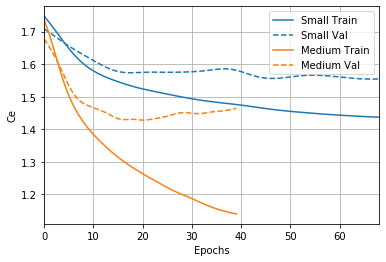

In [8]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'ce', smoothing_std=10)
plotter.plot(histories)

In [9]:
large = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(500, activation='relu'),
    Dense(500, activation='relu'),
    Dense(500, activation='relu'),
    Dense(10)
])

histories['large'] = compile_and_fit(large, 'large')

Epoch 1/1000
782/782 [==============================] - 14s 17ms/step - loss: 1.8511 - ce: 1.8506 - accuracy: 0.3289 - val_loss: 1.6738 - val_ce: 1.6733 - val_accuracy: 0.4018

Epoch: 0, accuracy:0.3289,  ce:1.8506,  loss:1.8511,  val_accuracy:0.4018,  val_ce:1.6733,  val_loss:1.6738,  
.Epoch 2/1000
782/782 [==============================] - 15s 19ms/step - loss: 1.6610 - ce: 1.6611 - accuracy: 0.4018 - val_loss: 1.6589 - val_ce: 1.6577 - val_accuracy: 0.4075
.Epoch 3/1000
782/782 [==============================] - 14s 18ms/step - loss: 1.5736 - ce: 1.5735 - accuracy: 0.4339 - val_loss: 1.5879 - val_ce: 1.5880 - val_accuracy: 0.4305
.Epoch 4/1000
782/782 [==============================] - 13s 16ms/step - loss: 1.5136 - ce: 1.5133 - accuracy: 0.4545 - val_loss: 1.5265 - val_ce: 1.5266 - val_accuracy: 0.4540
.Epoch 5/1000
782/782 [==============================] - 13s 17ms/step - loss: 1.4706 - ce: 1.4712 - accuracy: 0.4725 - val_loss: 1.4672 - val_ce: 1.4670 - val_accuracy: 0.4771
.Epo

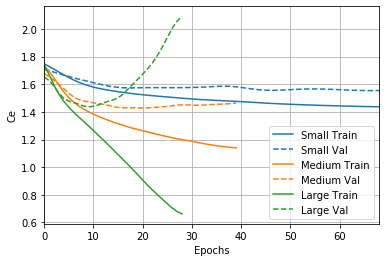

In [10]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'ce', smoothing_std=10)
plotter.plot(histories)

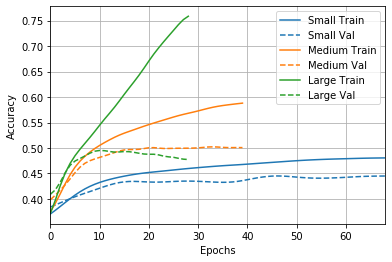

In [11]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(histories)